In [ ]:
"""
Goal is to fit a good next-note predictor on a lambda function with reasonable prediction speeds
"""

'\nGoal is to fit a good next-note predictor on a lambda function with reasonable prediction speeds\n'

In [ ]:
# basic matplotlib theme of Clouds Midnight
# NOTE: this does not support 3d plots
from matplotlib import rcParams
from cycler import cycler
rcParams['axes.prop_cycle']=cycler(color=['#e92e2e','#616161','#606060'])
rcParams['axes.edgecolor']='#929292'
rcParams['axes.labelcolor']='#929292'
rcParams['xtick.color']='#929292'
rcParams['ytick.color']='#929292'
rcParams['text.color']='#929292'
rcParams['figure.edgecolor']='#929292'
rcParams['grid.color']='#929292'
rcParams['grid.linestyle']=':'
rcParams['axes.facecolor']='#1c1c1c'
rcParams['figure.facecolor']='#1c1c1c'


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jembishop1/classical-music-piano-rolls")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/classical-music-piano-rolls


In [ ]:
"""
Loading data
"""

'\nLoading data\n'

In [ ]:
import os

os.listdir(path)

['music', 'music.pk']

In [ ]:
import shutil

def clear_tensorboard():
  parent = "lightning_logs"
  if os.path.exists(parent):
    for path in os.listdir(parent):
        p = os.path.join(parent, path)
        if os.path.isdir(p):
            shutil.rmtree(p)
        else:
            os.remove(p)

clear_tensorboard()

In [ ]:
import pickle

with open(f"{path}/music.pk", "rb") as f:
    obj1 = pickle.load(f) #data dict

/tmp/ipython-input-204379881.py:4: DeprecationWarning: Please import `coo_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.coo` namespace is deprecated and will be removed in SciPy 2.0.0.
  obj1 = pickle.load(f) #data dict


In [ ]:
'''with open(f"{path}/music/music.pk", "rb") as f:
    obj2 = pickle.load(f) #same thign

len(obj1), len(obj2), obj1[0], obj2[0]'''

'with open(f"{path}/music/music.pk", "rb") as f:\n    obj2 = pickle.load(f) #same thign\n\nlen(obj1), len(obj2), obj1[0], obj2[0]'

In [ ]:
try:
  import pypianoroll
except ModuleNotFoundError:
  !pip install pypianoroll
  import pypianoroll

from IPython.display import clear_output

clear_output()
print("Imported pnoroll")

Imported pnoroll


In [ ]:
"""
Looking at the pianoroll representation of the data
"""

'\nLooking at the pianoroll representation of the data\n'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(42)



def sparse_to_pianoroll(sparse_matrix):
    arr = sparse_matrix.toarray()
    track = pypianoroll.Track(
        name='Piano',
        program=0,
        is_drum=False
    )
    track.piano_roll = arr
    return track

datasize = 100
obj1 = np.random.choice(obj1, datasize)

start = time.time()
all_pieces = []
batch_size = 16
for i in range(0, len(obj1), batch_size):
    batch = [sparse_to_pianoroll(obj1[j]['piece']) for j in range(i, min(i+batch_size, len(obj1)))]
    all_pieces += batch
    time.sleep(0.5)
end = time.time()
print(f"Converted in {end-start}s")

Converted in 4.414885520935059s


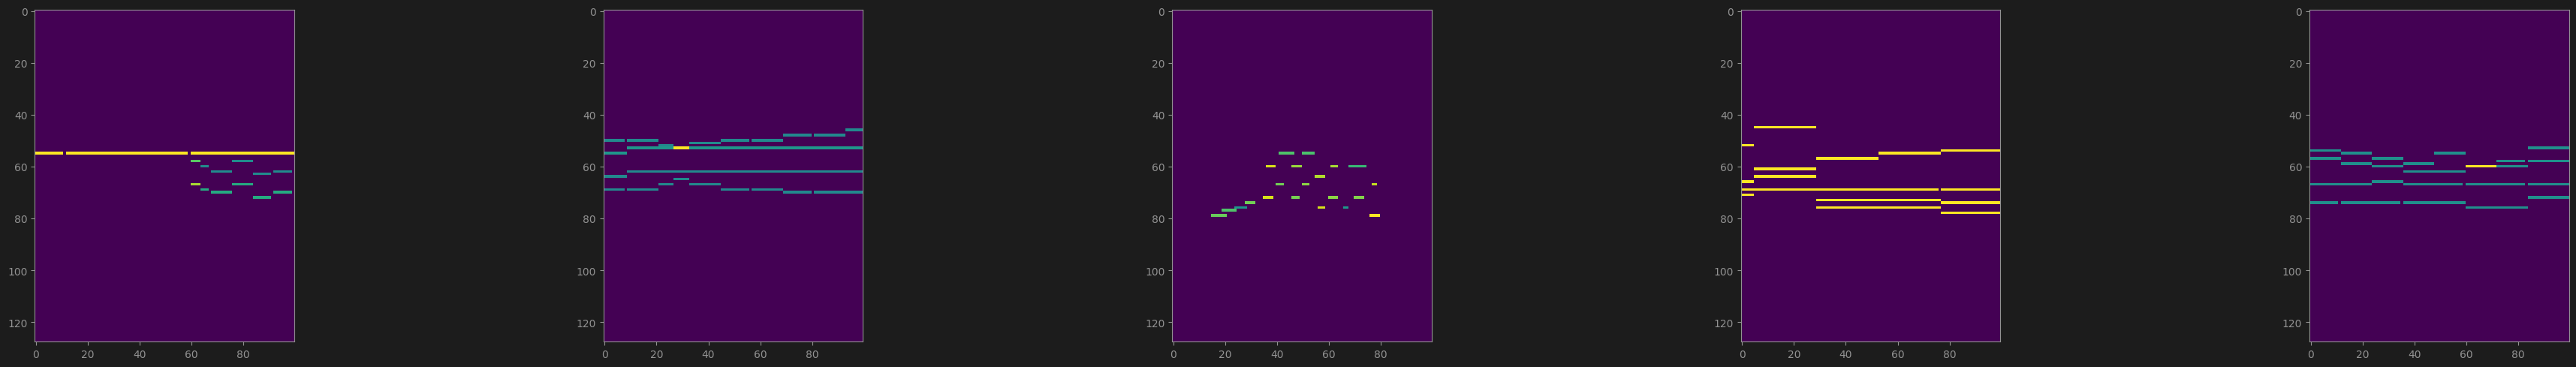

In [ ]:
plt.figure(figsize=(40, 5))
samples = np.random.choice(len(all_pieces), 5)

slice_len = 100

for idx, i in enumerate(samples):
    pr = all_pieces[i].piano_roll

    total_timesteps = pr.shape[0]
    if total_timesteps <= slice_len:
        start_idx = 0
    else:
        start_idx = np.random.randint(0, total_timesteps - slice_len)

    snippet = pr[start_idx:start_idx + slice_len]

    plt.subplot(1, 5, idx + 1)
    plt.imshow(snippet.T)


plt.tight_layout()
plt.show()


100
1319592 117485


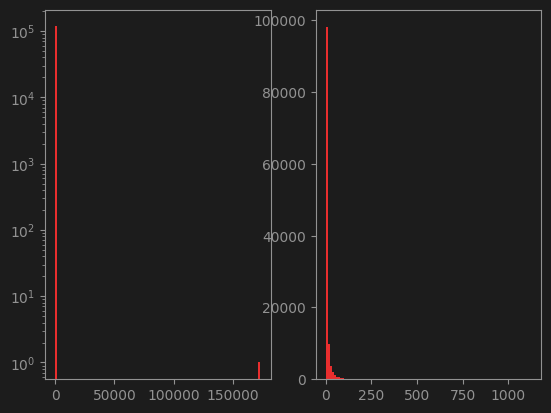

In [ ]:
arrays = [piece.piano_roll for piece in all_pieces]
print(len(arrays))

all_bars = list(np.concatenate(arrays))
unique_bars, counts = np.unique(all_bars, axis = 0, return_counts = True)
print(len(all_bars), len(unique_bars))

plt.subplot(1, 2, 1)
plt.yscale('log')
plt.hist(counts, bins = 100) #Makes little sense to try and do one category per unique bar bc severe overclassification

plt.subplot(1, 2, 2)
plt.hist(counts[1:], bins = 100)
plt.show() #Still no too inflated

In [ ]:
"""
Check for accents
Check for repeated sequences
If we predict by single note, we might get too little rests
But if we predict by single bars, we might get too many rests
"""

'\nCheck for accents\nCheck for repeated sequences\nIf we predict by single note, we might get too little rests\nBut if we predict by single bars, we might get too many rests\n'

In [ ]:
"""
using these notations for an eventual more complex dataset
Tenuto	– (dash)	Slight emphasis, sustain	~65–80
Normal	(none)	Default attack	~50–70
Accent	>	Stronger emphasis	~80–100
Marcato	^ (triangle)	Very strong, short emphasis	~100–120
Fortissimo hit	(none in score)	Max energy, typically percussive	~120–127

we're gonna try
- classification with 0s and 1s
- classification as regression
- classification with accents
"""

"\nusing these notations for an eventual more complex dataset\nTenuto\t– (dash)\tSlight emphasis, sustain\t~65–80\nNormal\t(none)\tDefault attack\t~50–70\nAccent\t>\tStronger emphasis\t~80–100\nMarcato\t^ (triangle)\tVery strong, short emphasis\t~100–120\nFortissimo hit\t(none in score)\tMax energy, typically percussive\t~120–127\n\nwe're gonna try\n- classification with 0s and 1s\n- classification as regression\n- classification with accents\n"

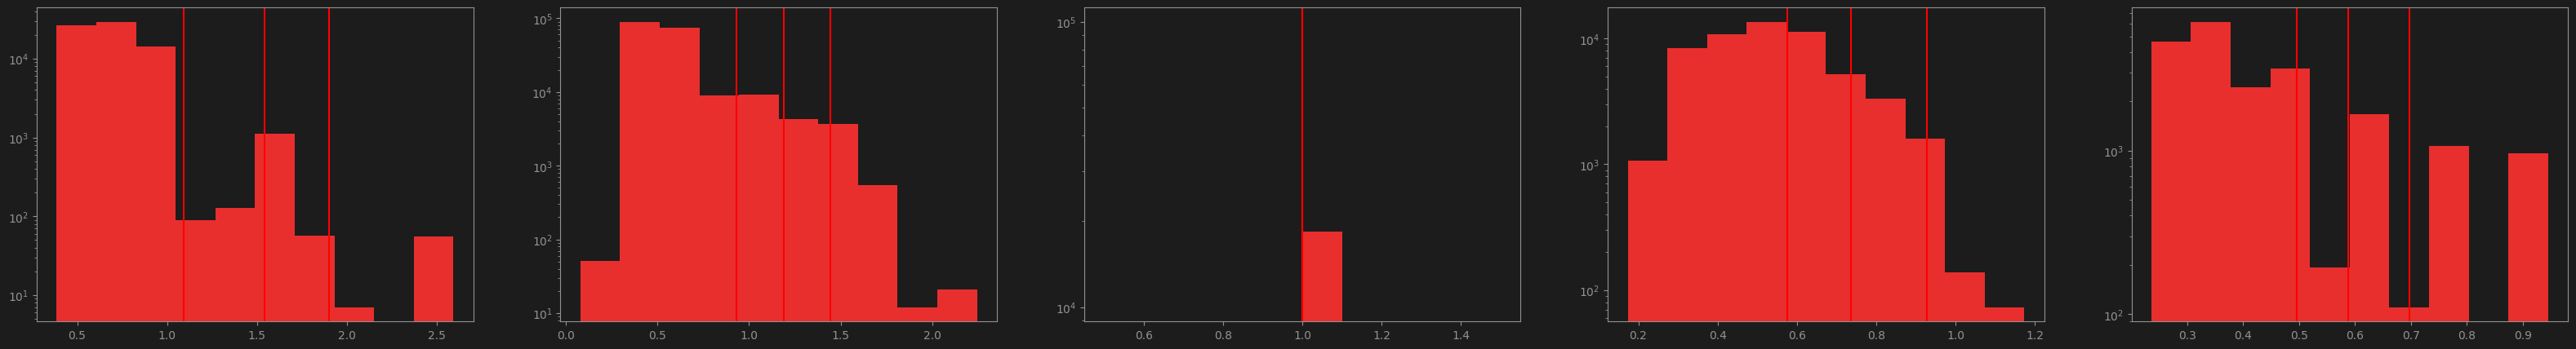

In [ ]:
n_sampels = 5
samples = np.random.choice(len(all_pieces), n_sampels)

plt.figure(figsize=(40, 5))
for idx in range(n_sampels):
    note_data = all_pieces[samples[idx]].piano_roll.flatten()
    note_data = note_data[note_data > 0]

    u = np.unique(note_data)
    cutoffs = [
        np.quantile(u, 0.5), #Tenuto
        np.quantile(u, 0.7), #Accent
        np.quantile(u, 0.9), #Marcato
    ]

    plt.subplot(1, n_sampels, idx + 1)
    plt.hist(note_data)
    plt.yscale('log')

    for c in cutoffs:
        plt.axvline(x = c, color = 'red')



plt.show() #These look p good

In [ ]:
n_tokens_pred = 48
n_tokens_gen = 20 # To Start
n_tokens = n_tokens_pred + n_tokens_gen
#48 to start with, and it's good for generating on composed music
#We wanna overdo predicting at beginning to get good at new music from scratch
#And make sure we put the end to that's also prioritized

tokens = []
accented_tokens = []
binarized_tokens = []

n_samples_per = 30

for piece in all_pieces:
    note_data = piece.piano_roll

    '''u = np.unique(note_data.flatten())
    cutoffs = [
        np.quantile(u, 0.5), #Tenuto
        np.quantile(u, 0.7), #Accent
        np.quantile(u, 0.9), #Marcato
    ]


    data_to_use = []
    data_to_use.append(note_data[-n_tokens:])'''

    #We're training a GAN and this can confuse the GAN - we'll get good noise anyway so no need to do this in case of a cold start
    data_to_use = []
    for _ in range(n_samples_per):
      start = np.random.randint(0, len(note_data) - n_tokens)
      data_to_use.append(note_data[start : start + n_tokens])
    tokens += data_to_use

'''
    tokens += data_to_use
    for data in data_to_use:

      binarized_data = np.vectorize(lambda x :
        0 if x == 0 else 1
      )(data)
      binarized_tokens.append(binarized_data)

      accented_data = np.vectorize(lambda x :
        0 if x == 0 else
        1 if x < cutoffs[0] else
        2 if x < cutoffs[1] else
        3 if x < cutoffs[2] else
        4
      )(data)
      accented_tokens.append(accented_data)'''


tokens = np.array(tokens)
binarized_tokens = np.array(binarized_tokens)
accented_tokens = np.array(accented_tokens)

tokens.shape, binarized_tokens.shape, accented_tokens.shape

((3000, 68, 128), (0,), (0,))

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split

class Dataset(Dataset):
    def __init__(self, data):
        self.original_data = data #

        #Randomly pick half the data to mismatch (could also make it easier using noise)
        self.labels = np.random.randint(0, 2, size=data.shape[0])
        nontruth_indices = [idx for idx, i in enumerate(self.labels) if i == 1]
        random_indices = np.random.choice(nontruth_indices, len(nontruth_indices) // 2)
        nontruth_indices = [idx for idx in nontruth_indices if idx not in random_indices]

        #Make half of these shuffled
        for idx in nontruth_indices:
          d1 = data[idx][:n_tokens_pred]
          indices_to_select = [idx for idx, i in enumerate(self.labels) if i != idx]
          ridx = np.random.choice(indices_to_select, 1)[0]
          random_d2 = data[ridx][n_tokens_pred:n_tokens_pred + n_tokens_gen]
          data[idx] = np.concatenate(( d1, random_d2 ), axis = 0)

        #Make half of these random
        for idx in random_indices:
          d1 = data[idx][:n_tokens_pred]
          random_d2 = np.random.random((n_tokens_gen, 128))
          data[idx] = np.concatenate(( d1, random_d2 ), axis = 0)

        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        original = self.original_data[idx] #So we can reuse this
        x1 = sample[:n_tokens_pred]
        x2 = sample[n_tokens_pred:n_tokens_pred + n_tokens_gen]
        y = self.labels[idx]
        return (torch.tensor(x1).float(), torch.tensor(x2).float(), torch.tensor(original).float()), torch.tensor(y).float()


tokens_dataset = Dataset(tokens)

train_size = int(0.8 * len(tokens_dataset))
val_size = len(tokens_dataset) - train_size

tokens_train_dataset, tokens_val_dataset = random_split(tokens_dataset, [train_size, val_size])

batch_size = 32
tokens_train = DataLoader(tokens_train_dataset, batch_size=batch_size, shuffle=True)
tokens_test = DataLoader(tokens_val_dataset, batch_size=batch_size, shuffle=True)


x, y = next(iter(tokens_train))
x[0].shape, x[1].shape, x[2].shape, y.shape

(torch.Size([32, 48, 128]),
 torch.Size([32, 20, 128]),
 torch.Size([32, 68, 128]),
 torch.Size([32]))

In [ ]:
def plot(g):
  #Looking at some generations
  batch = next(iter(tokens_train))
  x, y = batch
  xpred, xgen, _ = tuple(x)
  xpred = xpred.to(device); xgen = xgen.to(device); y = y.to(device)
  #g = g.to(device)
  with torch.no_grad():
    gen = g(xpred)
    gen.shape


  topn = 3
  N = topn
  i = 1

  plt.figure(figsize = [20, 5])

  for batch_idx in range(32):
    if N == 0:
      break

    xp = xpred[batch_idx]
    xg = xgen[batch_idx] #True gen
    p = gen[batch_idx] #Predicted gen
    p = p.cpu()

    cutoff = torch.quantile(torch.flatten(p), 0.9)
    #p = p.cpu().apply_(lambda x : x if x > cutoff else 0)

    true = torch.cat((xp, xg)).cpu().numpy()
    pred = torch.cat((xp.cpu(), p)).numpy()

    plt.subplot(1, topn * 2, i)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(true.T)
    plt.subplot(1,  topn * 2, i + 1)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(pred.T)

    i += 2
    N -= 1

  plt.tight_layout()
  plt.show()


In [ ]:
"""Storage:
- Ephemeral storage (/tmp): 512 MB (default, not expandable in free tier).
- Deployment package size:
    * Compressed (.zip): up to 50 MB (direct upload) or 250 MB (via Amazon S3).
    * Uncompressed: up to 250 MB, including layers.

Memory (RAM):
- Configurable from 128 MB to 10,240 MB (10 GB), in 1 MB increments.
- Free limit = 150 MB configured
- CPU power scales proportionally with memory size.
"""

'Storage:\n- Ephemeral storage (/tmp): 512 MB (default, not expandable in free tier).\n- Deployment package size:\n    * Compressed (.zip): up to 50 MB (direct upload) or 250 MB (via Amazon S3).\n    * Uncompressed: up to 250 MB, including layers.\n\nMemory (RAM):\n- Configurable from 128 MB to 10,240 MB (10 GB), in 1 MB increments.\n- Free limit = 150 MB configured\n- CPU power scales proportionally with memory size.\n'

In [ ]:
#Utils
!pip install pytorch_lightning
%load_ext tensorboard
clear_output()

In [ ]:
from torchsummary import summary
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
import pytorch_lightning as pl

device = 'cuda'

class Discriminator2(nn.Module): #Tries to discriminate from a random value - lightweight
    def __init__(self, input_shape_1, input_shape_2, embed_dim, n_heads, n_blocks,
                 n_linear_blocks, hidden_dim, dropout, out_activation):
        super().__init__()

        #Layers
        l1 = input_shape_1[0]; l2 = input_shape_2[0]

        self.projection = nn.Linear(input_shape_1[1], embed_dim)

        self.stack1 = nn.ModuleList([nn.Sequential(
              nn.MultiheadAttention(embed_dim, n_heads, batch_first = True), nn.Dropout(dropout), nn.LayerNorm((l1, embed_dim))
         ) for _ in range(n_blocks)])


        self.stack2 = nn.ModuleList([nn.Sequential(
              nn.MultiheadAttention(embed_dim, n_heads, batch_first = True), nn.Dropout(dropout), nn.LayerNorm((l2, embed_dim))
         ) for _ in range(n_blocks)])

        """
        Second approach to try would be first passing into stack1, then concat and pass into stack2 (w mask)
        """

        self.ff_stack = []
        current = embed_dim; target = hidden_dim
        T = []
        divideby = current // n_linear_blocks
        for _ in range(n_linear_blocks):

            self.ff_stack += [nn.Linear(current, target), nn.ReLU(), nn.Dropout(dropout / 2), nn.LayerNorm((l1 + l2, target))]

            current = target
            T.append(target)
            target = target // divideby


        self.ff_stack = nn.ModuleList(self.ff_stack)
        self.out_linear = nn.Linear(T[-1] * (l1 + l2), 1)
        self.out_activation = out_activation



    def forward(self, x, y): #Trains to check if y is a good successor of X - The one that hopefully works
        x = x.float()
        y = y.float()
        x = self.projection(x)
        y = self.projection(y)

        def main_stack(x, stack):
          for module_stack in stack:
            main, drop, norm = module_stack[0], module_stack[1], module_stack[2]
            mout = x
            try:
              mout = main(x, x, x)[0]
            except Exception as e:
              mout = main(x)[0]
            x = mout + drop(x)
            x = norm(x)
          return x


        x = main_stack(x, self.stack1)
        y = main_stack(y, self.stack2)

        x = torch.cat((x, y), dim = 1)

        for layer in self.ff_stack:
          x = layer(x)

        b, c, s = tuple(x.shape)
        x = x.view(b, c * s)
        x = self.out_linear(x)

        if self.out_activation is not None:
          x = x.squeeze()
          x = self.out_activation(x)

        return x






In [ ]:
d2 = Discriminator2(
                    input_shape_1 = (n_tokens_pred, 128),
                    input_shape_2 = (n_tokens_gen, 128),
                    embed_dim = 128,
                    n_heads = 4,
                    n_blocks = 1,
                    n_linear_blocks = 1,
                    hidden_dim = 128,
                    dropout = 0.2,
                    out_activation = lambda x : x
).to(device)

summary(d2, [ (n_tokens_pred, 128) , (n_tokens_gen, 128) ])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 48, 128]          16,512
            Linear-2              [-1, 20, 128]          16,512
MultiheadAttention-3  [[-1, 48, 128], [-1, 48, 48]]               0
           Dropout-4              [-1, 48, 128]               0
         LayerNorm-5              [-1, 48, 128]          12,288
MultiheadAttention-6  [[-1, 20, 128], [-1, 20, 20]]               0
           Dropout-7              [-1, 20, 128]               0
         LayerNorm-8              [-1, 20, 128]           5,120
            Linear-9              [-1, 68, 128]          16,512
             ReLU-10              [-1, 68, 128]               0
          Dropout-11              [-1, 68, 128]               0
        LayerNorm-12              [-1, 68, 128]          17,408
           Linear-13                    [-1, 1]           8,705
Total params: 93,057
Trainable 

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()
clear_tensorboard()

d_start = d2.state_dict()

n_tokens_pred, n_tokens_gen

(48, 20)

In [ ]:
def model_check(sample):
  x = torch.randn(32, 48, 128, device=device)
  torch.cuda.reset_peak_memory_stats(device)
  model = sample.to(device)

  with torch.no_grad():
      y = model(x)
      print(x.shape, y.shape)

  print("Memory used (MB):", torch.cuda.max_memory_allocated(device) / 1024**2)

In [ ]:
class Generator(pl.LightningModule): #Tries to discriminate from a random value - lightweight
    def __init__(self, input_shape, pred_shape, latent_dim, hidden_dim, n_encoder_blocks,
                 n_decoder_blocks, dropout,  discriminator, disc_penalty, kl_penalty, var_penalty, glr, dlr, i, j, rand_size):
        super().__init__()
        self.save_hyperparameters(ignore=['out_activation'])


        #For Train
        self.bce = nn.BCEWithLogitsLoss()
        self.reg_loss = nn.KLDivLoss()
        self.discriminator = discriminator
        self.epoch = 0

        #Contsntas
        self.alpha = kl_penalty
        self.beta = var_penalty
        self.eta = disc_penalty
        self.dlr = dlr
        self.glr = glr
        self.i = i
        self.j = j


        #For plotting
        self.epoch_gen_val_loss = []
        self.epoch_disc_val_loss = []
        self.epoch_gen_train_loss = []
        self.epoch_disc_train_loss = []
        self.train_checkpoints = []
        self.rand_size = rand_size



        self.automatic_optimization = False
        self.batch_counter = 0 #To decide what to train

        #Layers
        seqlen, featlen = tuple(input_shape)
        outseqlen = pred_shape[0]

        '''
        Not using projection or embed dim as to save parameters
        Embed dim will be the latent space
        Right now we're controlling the downsampling, but it might be better to infer it
        '''

        modules = []
        size = seqlen + rand_size
        factor = 0.95 #Not too much decay
        ft = featlen
        ft_factor = max(int(round((hidden_dim / featlen) ** (1 / n_encoder_blocks))), 1)
        for _ in range(n_encoder_blocks):
          nextsize = int(size * factor)
          sequential = nn.Sequential(
              #nn.MultiheadAttention(embed_dim, n_heads, batch_first = True),
              nn.LSTM(ft, ft * ft_factor, batch_first = True),
              nn.Dropout(dropout),
              nn.AdaptiveAvgPool1d(nextsize), #Might not use, only at end
              nn.LayerNorm((nextsize))
          )
          modules.append(sequential)
          size = max(nextsize, 1)
          ft *= ft_factor

        #Snapping latent dim to a mod of size
        while size % latent_dim != 0:
          latent_dim += 1

        self.encoder = nn.ModuleList(modules)
        self.feat_projection = nn.AvgPool1d(kernel_size=ft // featlen, stride=ft // featlen)
        self.projection = nn.AvgPool1d(kernel_size=size // latent_dim, stride=size // latent_dim)

        modules = []
        factor = 2
        cdim = featlen
        for _ in range(n_decoder_blocks):
          sequential = nn.Sequential(
              nn.ConvTranspose1d(cdim, cdim * factor, kernel_size = 4, stride = 2, padding = 1),
              nn.LeakyReLU(0.2)
          )
          modules.append(sequential)
          cdim *= factor


        self.decoder = nn.ModuleList(modules)

        #Gets size of block
        dummy = torch.randn(1, featlen, latent_dim)  # batch=1
        for block in self.decoder:
            dummy = block(dummy)


        ksize = 2
        stride = int((dummy.shape[-1] - (ksize - 2)) / (outseqlen - 1))

        conv = nn.Conv1d(dummy.shape[1], featlen, kernel_size = ksize, stride = stride, padding = 1)
        shape = conv(dummy).shape


        #Mainly for smoothing and shape projection
        self.out_projection = nn.Sequential(
            nn.Conv1d(dummy.shape[1], featlen, kernel_size = ksize, stride = stride, padding = 1),
            nn.LeakyReLU(0.2),
            nn.Linear(shape[2], outseqlen)
        )
        self.out_projection_feats = nn.Linear(shape[1], 128)

        self.out_activation = lambda x : F.sigmoid(x)







    def forward(self, x): #(batch, sqelen, feats)
      x = x.float()

      a, b, _ = tuple(x.shape)
      x = torch.cat((x, torch.randn(a, b, self.rand_size).to(x.device)), dim=-1)

      for module_stack in self.encoder:
          lstm, drop, downsample, norm = module_stack #Downsample = norm, pool, or both
          x, _ = lstm(x)
          x = drop(x)
          x = x.permute(0, 2, 1)
          x = downsample(x) #On sequence length
          #x = norm(x)
          x = x.permute(0, 2, 1)

      x = self.feat_projection(x) #Corrects transformations of hidden size
      x = x.permute(0, 2, 1)
      x = self.projection(x) #Corrects mistakes in latent dim


      for module_stack in self.decoder:
        x = module_stack(x)

      x = self.out_projection(x) #Same purpose as projection before
      x = x.permute(0, 2, 1) #(batch, seqlen, feats)
      x = self.out_projection_feats(x)
      x = self.out_activation(x)

      return x














    def training_step(self, batch, batch_idx):
        x, y = batch
        xpred, xgen, fullx = tuple(x)
        xpred = xpred.to(device); xgen = xgen.to(device); y = y.to(device)

        i, j = self.i, self.j
        k = 0

        op_idx = 0 #bc = 0 to 20
        if self.batch_counter >= i:
          if self.batch_counter == i:
            k = 'd'
          op_idx = 1 #op_idx = 1 if switching is on
        self.batch_counter += 1
        if self.batch_counter == j:
          self.batch_counter = 0
          k = 'g'

        #self.train_checkpoints.append(k)

        opt_g, opt_d = self.optimizers()

        if True:

          #Optimize Generator
          gen = self(xpred)
          batch_size, seq_len, feat_dim = gen.shape
          dout = self.discriminator(xpred, gen).to(device)

          #WDist
          mainloss = -torch.mean(dout)


          #Standard MAE
          truth_gen = fullx[:, n_tokens_pred:n_tokens_pred + n_tokens_gen]
          rloss = self.reg_loss(F.log_softmax(gen, dim = 1), F.softmax(truth_gen, dim = 1))

          #Cosine dist
          closs = F.cosine_similarity(gen.unsqueeze(1), gen.unsqueeze(0), dim=-1)
          mask = ~torch.eye(gen.size(0), dtype=bool, device=gen.device)
          closs = closs[mask].mean()


          alpha = self.alpha
          beta = self.beta
          eta = self.eta

          loss = (mainloss * eta)  + (closs * beta) #  + (rloss * alpha)
          self.log("train_gen_loss", loss, prog_bar=True)
          self.epoch_gen_train_loss.append(loss.item())

          if op_idx == 0:
            opt_g.zero_grad()
            self.manual_backward(loss)
            opt_g.step()

            return loss

        if True:
          #Optimize discriminator further
          with torch.no_grad():
            gen = self(xpred)
          ridx = np.random.choice([idx for idx, i in enumerate(y)], int(len(y) * 0.5)) #Replacing half with the generator's outputs
          xgen_clone = xgen.clone()
          y_clone = y.clone()
          for idx in ridx:
            xgen_clone[idx] = gen[idx]
            y_clone[idx] = 0

          logits = self.discriminator(xpred, xgen_clone).to(device)
          y_clone = y_clone.to(device)

          #Measure of WassDist
          dist_fake = logits[ridx].mean()
          dist_real = logits[~ridx].mean()
          loss = -dist_real + dist_fake


          self.log("train_disc_loss", loss, prog_bar=True)
          self.epoch_disc_train_loss.append(loss.item())

          if op_idx != 0:
            opt_d.zero_grad()
            self.manual_backward(loss)

            #Clamping
            for p in self.discriminator.parameters():
              p.data.clamp_(-0.01, 0.01)


            opt_d.step()

            return loss










    def validation_step(self, batch, batch_idx):
        x, y = batch
        xpred, xgen, fullx = tuple(x)
        xpred = xpred.to(device); xgen = xgen.to(device); y = y.to(device)
        gen = self(xpred)

        ridx = np.random.choice([idx for idx, i in enumerate(y)], int(len(y) * 0.5) ) #Replacing half with the generator's outputs
        xgen_clone = xgen.clone(); y_clone = y.clone()
        for idx in ridx:
          xgen_clone[idx] = gen[idx]
          y_clone[idx] = 0
        logits = self.discriminator(xpred, xgen_clone)

        #W loss (generator)
        mainloss = -logits[ridx].mean()

        #Dloss
        dist_fake = logits[ridx].mean()
        dist_real = logits[~ridx].mean()
        loss = -dist_real + dist_fake


        #Cosine penalty
        closs = F.cosine_similarity(gen.unsqueeze(1), gen.unsqueeze(0), dim=-1)
        mask = ~torch.eye(gen.size(0), dtype=bool, device=gen.device)
        closs = closs[mask].mean()


        alpha = self.alpha
        beta = self.beta
        eta = self.eta

        gen_loss = (mainloss * eta) + (closs * beta) #+ (rloss * alpha)

        self.log("val_gen_loss", gen_loss, prog_bar=True)
        self.log("val_disc_loss", loss, prog_bar=True)

        self.epoch_gen_val_loss.append(gen_loss.item())
        self.epoch_disc_val_loss.append(loss.item())







    def on_train_epoch_end(self):
      self.epoch += 1
      if self.epoch % 10 == 0:
        print(f"Epoch {self.epoch}")
        plot(self)

        val_loss_complete = self.epoch_gen_val_loss + self.epoch_disc_val_loss
        train_loss_complete = self.epoch_gen_train_loss + self.epoch_disc_train_loss


        plt.figure(figsize = [15, 5])
        plt.subplot(1, 2, 1)
        plt.title("Train")
        plt.plot(train_loss_complete[:len(self.epoch_gen_train_loss)], color = "green")
        plt.plot(train_loss_complete[len(self.epoch_gen_train_loss):], color = "red")

        plt.legend(["Generator", "Discriminator"])

        plt.subplot(1, 2, 2)
        plt.title("Validation")
        plt.plot(val_loss_complete[:len(self.epoch_gen_val_loss)])
        plt.plot(val_loss_complete[len(self.epoch_gen_val_loss):])
        plt.legend(["Generator", "Discriminator"])

        plt.tight_layout()
        plt.show()

        self.epoch_gen_val_loss = []
        self.epoch_disc_val_loss = []
        self.epoch_gen_train_loss = []
        self.epoch_disc_train_loss = []








    def configure_optimizers(self):
      opt_g = torch.optim.Adam(self.parameters(), lr=self.glr)
      opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.dlr)

      sch_g = torch.optim.lr_scheduler.ReduceLROnPlateau(
          opt_g, mode="min", factor=0.5, patience=5
      )
      sch_d = torch.optim.lr_scheduler.ReduceLROnPlateau(
          opt_d, mode="min", factor=0.5, patience=5
      )

      return (
          [opt_g, opt_d]
      )

      ''' [
              {"scheduler": sch_g, "monitor": "val_gen_loss"},
              {"scheduler": sch_d, "monitor": "val_disc_loss"},
          ],'''


'''
 def __init__(self, input_shape, pred_shape, latent_dim, n_encoder_blocks,
                 n_decoder_blocks, dropout, discriminator):
'''

'\n def __init__(self, input_shape, pred_shape, latent_dim, n_encoder_blocks,\n                 n_decoder_blocks, dropout, discriminator):\n'

In [ ]:
params = {
    "input_shape": (n_tokens_pred, 128),
    "pred_shape": (n_tokens_gen, 128),
    "latent_dim": 16,
    "hidden_dim": 224,
    "n_encoder_blocks": 3,
    "n_decoder_blocks": 3,
    "dropout": 0.2,
    "discriminator": d2,
    "disc_penalty" : 1,
    "kl_penalty" : 0.0,
    "var_penalty" : 0.3,
    "glr" : 1e-3,
    "dlr" : 1e-3,
    "i" : 3,
    "j" : 15,
    "rand_size" : 0
}



sample = Generator(**params).to(device)
model_check(sample)

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/parsing.py:210: Attribute 'discriminator' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['discriminator'])`.


torch.Size([32, 48, 128]) torch.Size([32, 20, 128])
Memory used (MB): 113.33642578125


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/parsing.py:45: Attribute 'discriminator' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['discriminator'])`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type              | Params | Mode 
----------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:484: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:3359: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10


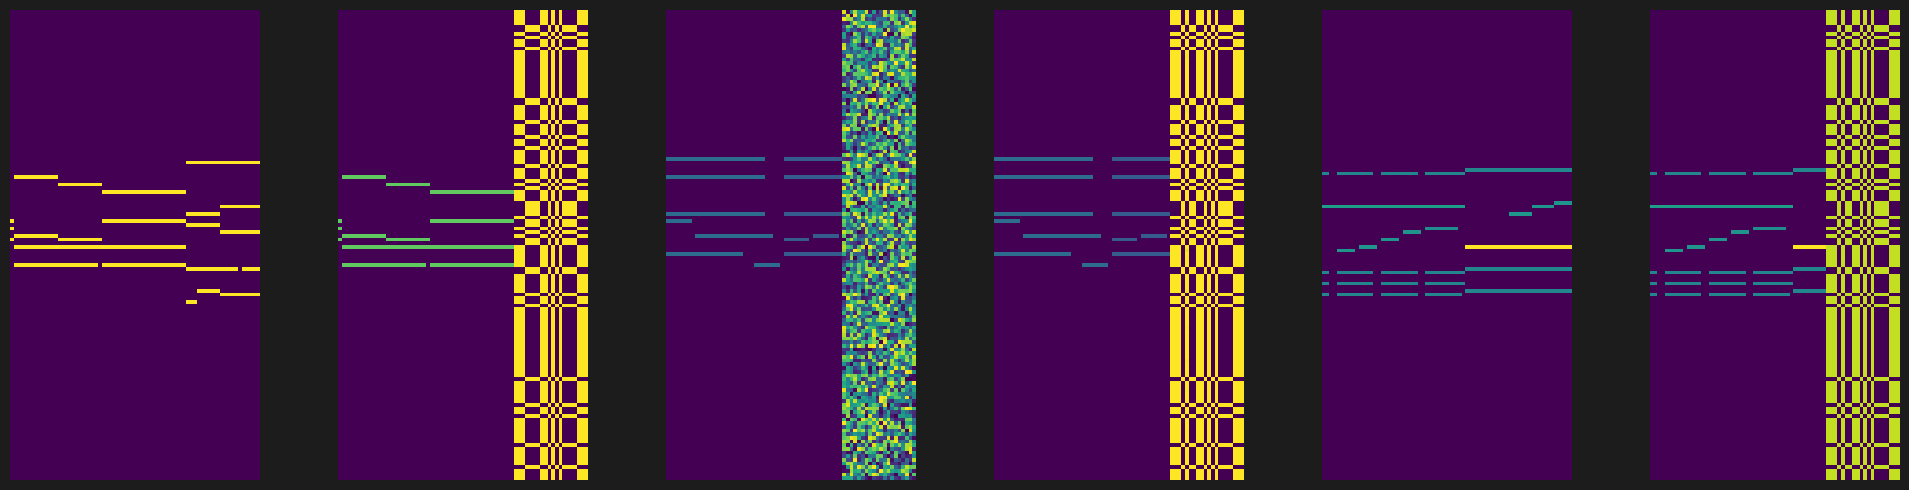

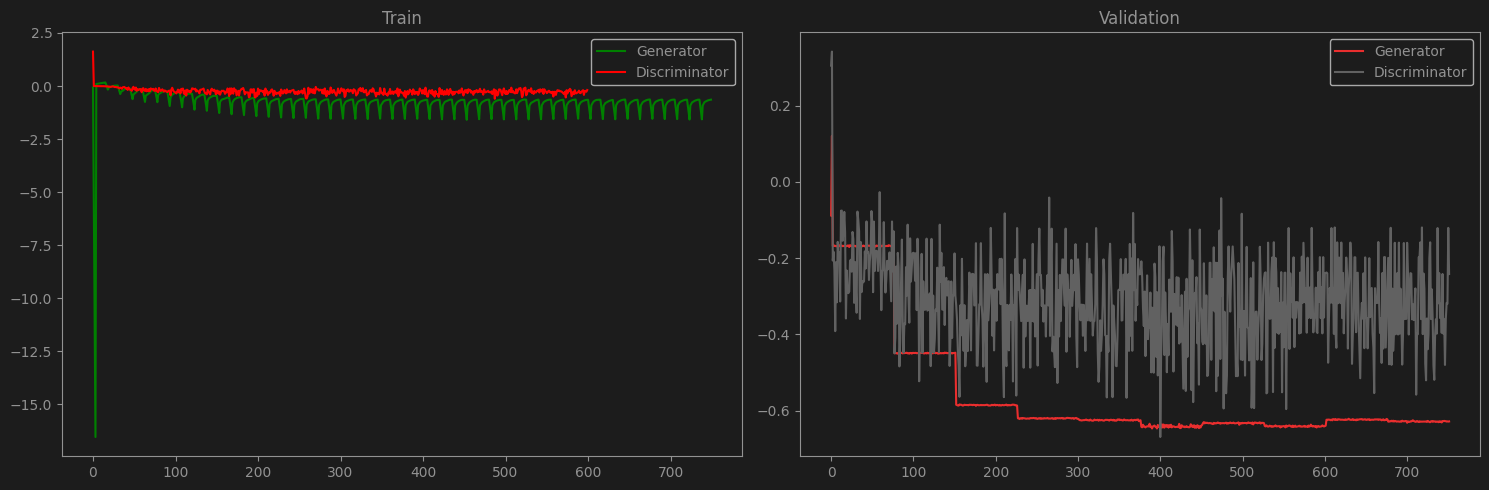

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20


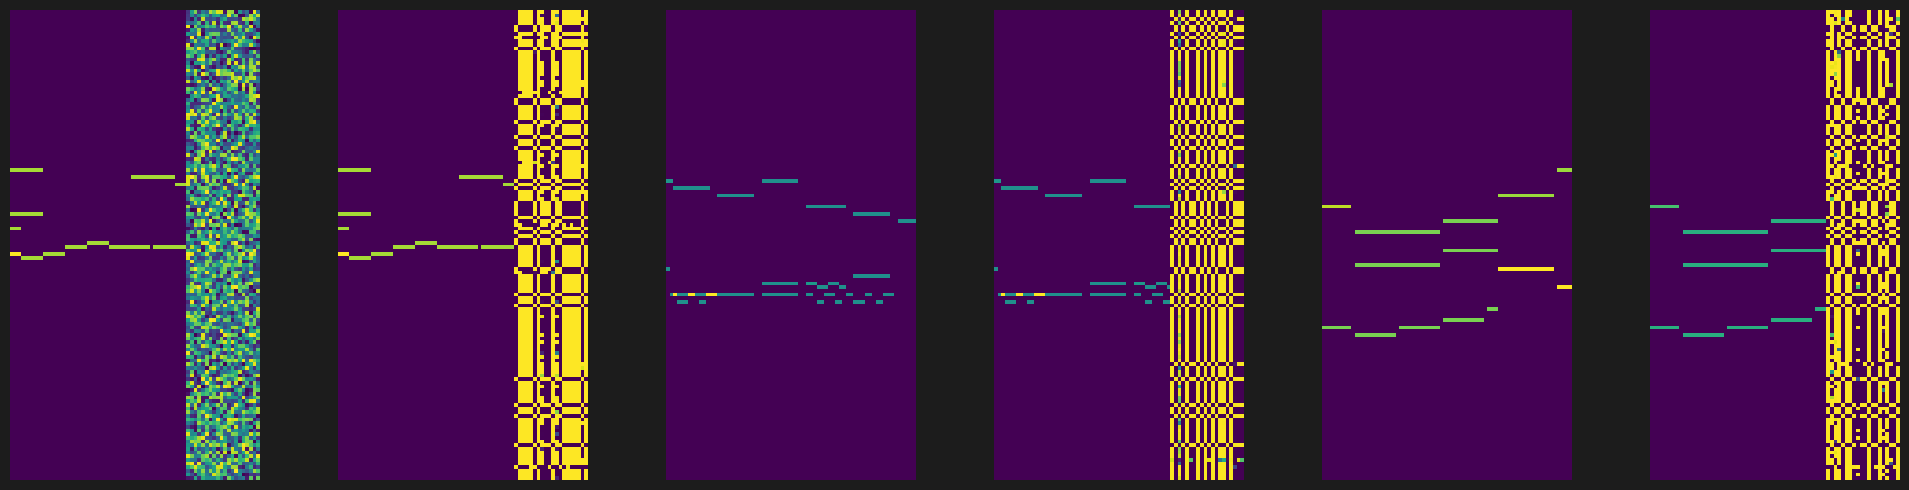

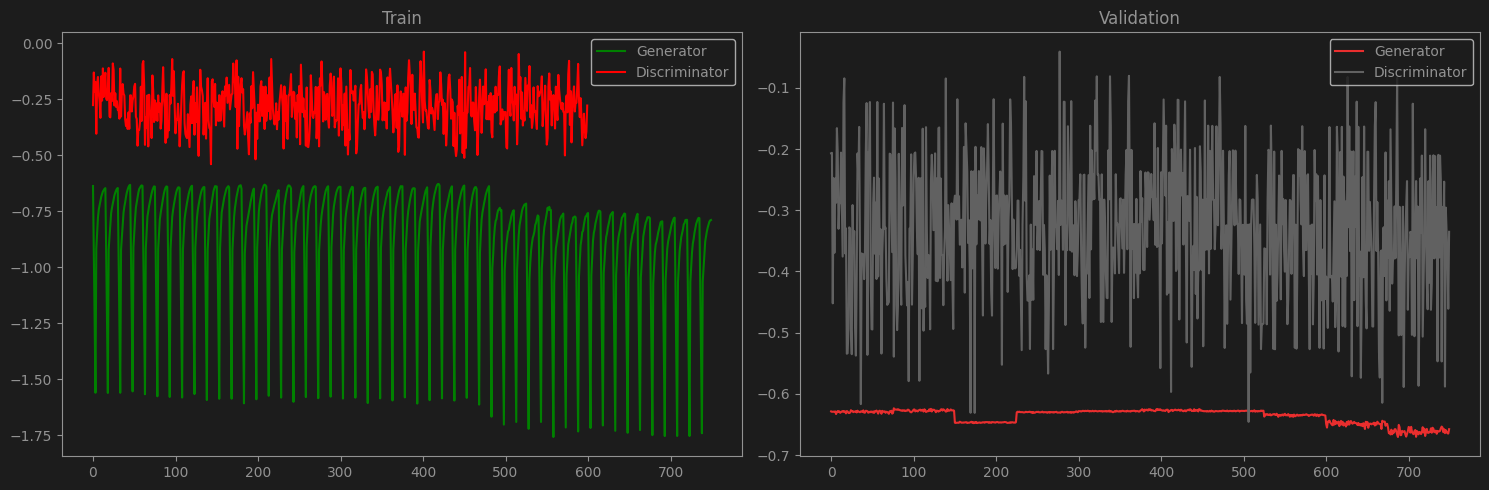

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30


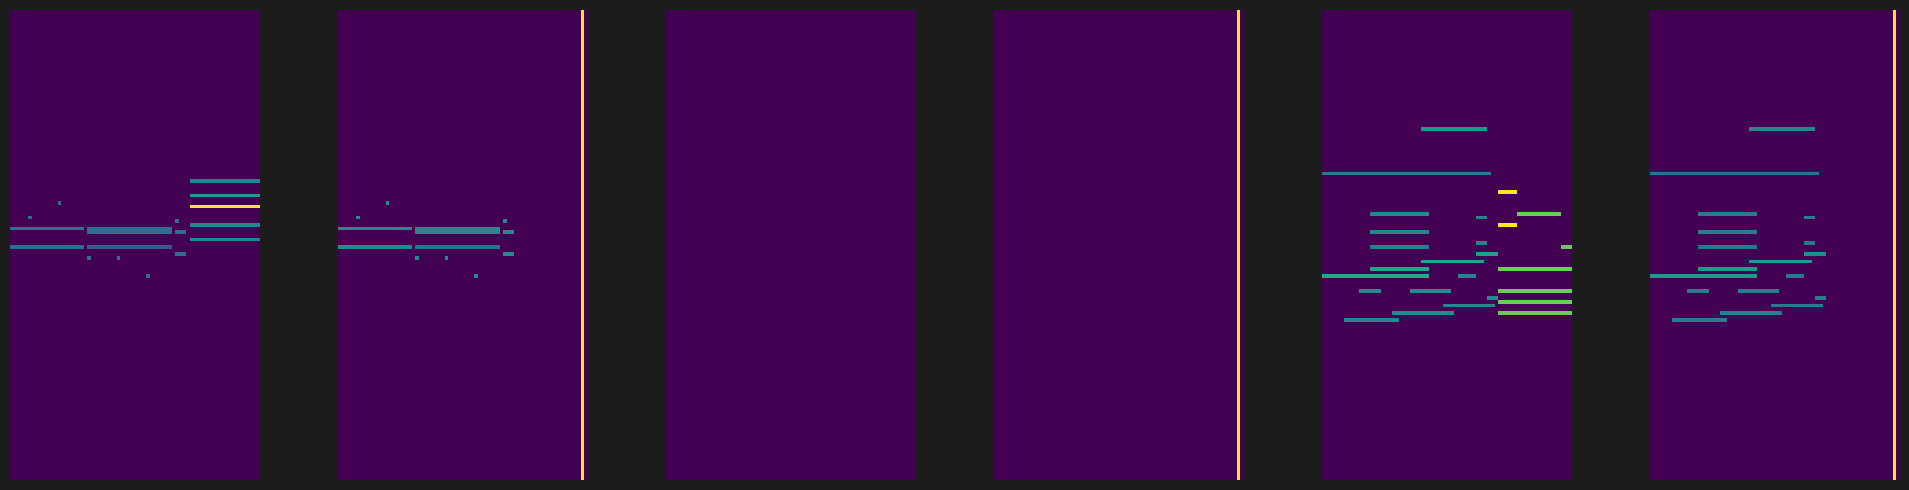

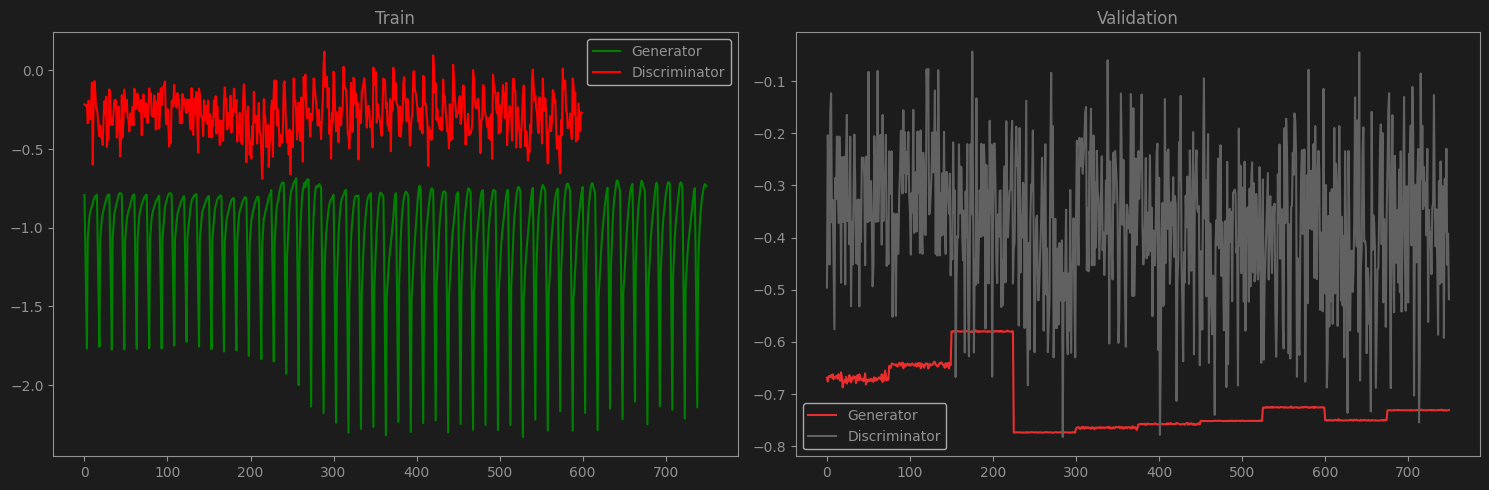

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40


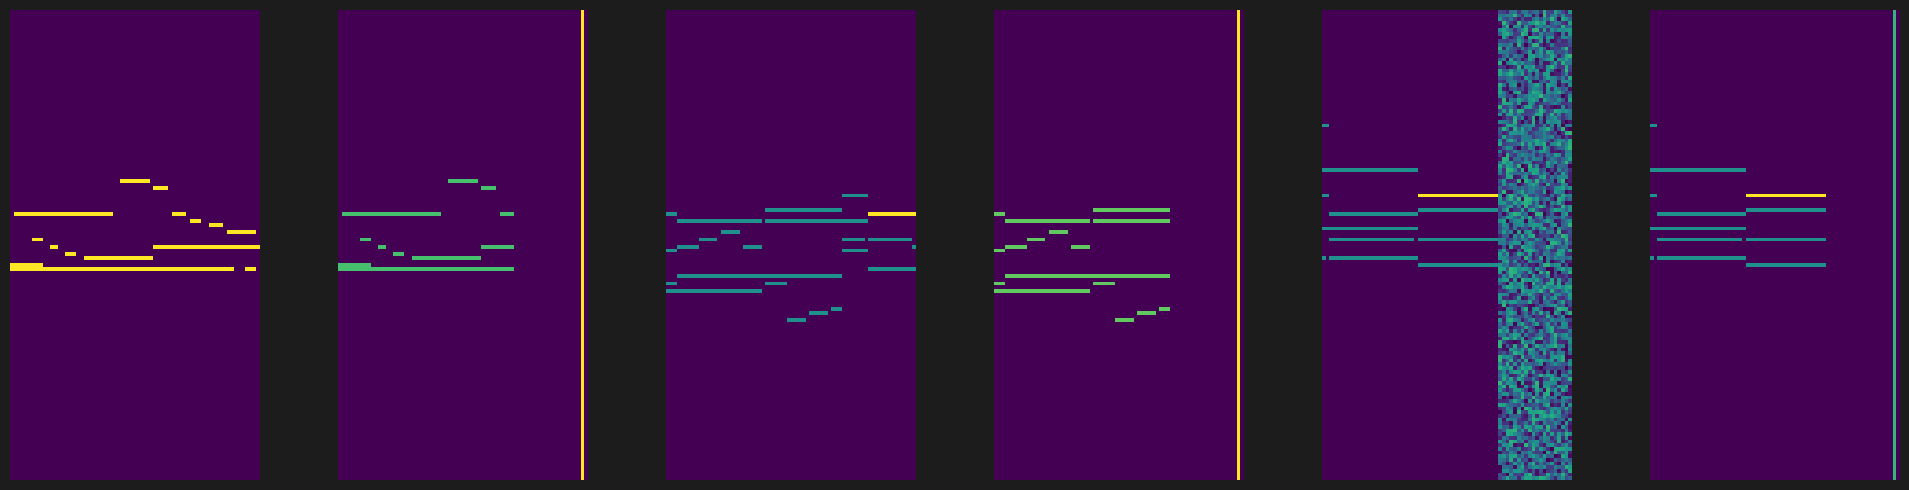

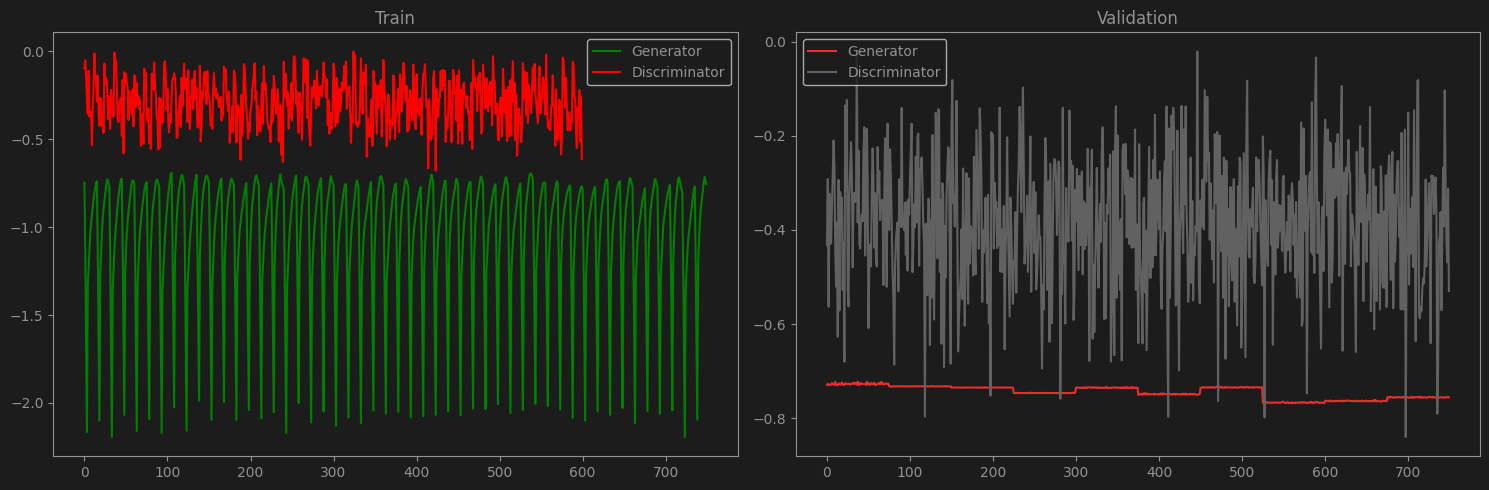

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


In [ ]:
d2.load_state_dict(d_start)

g = Generator(**params).to(device)

trainer = pl.Trainer(max_epochs=40, accelerator="auto")

trainer.fit(g, tokens_train, tokens_train)